## Hello Braket!

Wondering how to access Aquila? Say hello to Braket! 

The AWS Braket interface allows you to send tasks from your laptop to quantum processors at QuEra via the AWS cloud infrastructure. This tutorial will give you a first taste of what this workflow looks like. It's simple: Define the arrangement of atoms you want to use and specify your Hamiltonian parameters of choice to govern the behavior of those atoms. Submit the program and analyze the results. 

Ready to explore what's possible with Aquila? Let's dive straight in!


### Goal 

To say hello to the world of neutral atoms, let's investigate one of the central phenomena in quantum many-body physics: the emergence of **ordered phases of matter**. In this tutorial, we'll show how Aquila can prepare the simplest of such ordered phases, namely an antiferromagnetic phase (aka $\mathbb{Z_2}$ phase) in both one- and two-dimensional arrays of atoms. To make this possible, we will make use of the [Rydberg blockade](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/1.blockade/main/) - the mechanism at the heart of our quantum computing architecture.

### Register

Let's start off with the 1D case.   To achieve our goal, we first need to define our Rydberg-atom quantum computer register. We arrange them in a line with a separation of 6.1μm between each pair of atoms. 

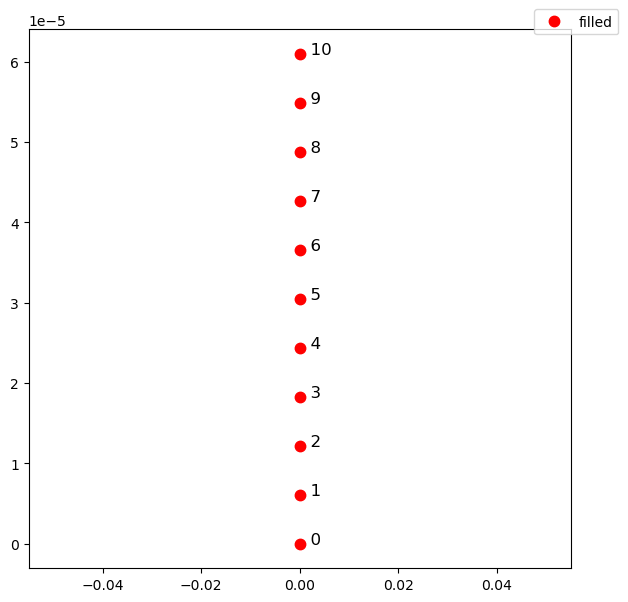

In [1]:
from braket.ahs.atom_arrangement import AtomArrangement
import numpy as np
from utils import show_register

a = 6.1e-6  # meters
N_atoms = 11

register = AtomArrangement()
for i in range(N_atoms):
    register.add([0.0, i*a])

fig = show_register(register)

### Hamiltonian

The next component we need to specify is the Hamiltonian. It's the energy function that governs the behaviour of our atoms, including their interactions. 

In the lab, the Hamiltonian is implemented by applying lasers to the atoms. 

In [3]:
from braket.ahs.hamiltonian import Hamiltonian

H = Hamiltonian()

Specifically, the Hamiltonian governing our system of atoms takes the following form:

\begin{align*}
H(t) = \frac{\Omega(t)}{2} \sum_j (e^{i \phi(t)}\ket{g_j}\bra{r_j} +  e^{-i \phi(t)}\ket{r_j}\bra{g_j}) - \sum_j \Delta(t)\hat{n}_j + \sum_{j<k} V_{jk}\hat{n}_j\hat{n}_k,
\end{align*}

where $\Omega$, $\phi$ and $\Delta$ denote the Rabi frequency, laser phase, and the detuning of the driving laser field coupling the ground states $\ket{g_j}$ and excited Rydberg state $\ket{r_j}$ of the j-th atom. Our task is to specify these Hamiltonian parameters ($\Omega$, $\phi$ and $\Delta$). Here, they will be time-dependent in order to help us carry out a protocol called adiabiatic state preparation. In case this sounds unfamiliar, feel free to read up on the physics background on our open source platform [Bloqade](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/2.adiabatic/main/).


In our current case, we only want to tell the system to activate the set of lasers controlling the Rabi frequency and the global detuning. In particular, we will choose a constant Rabi frequency of $\Omega=2.5\times10^6$ rad/s and a linearly increasing detuning from $\Delta = -9\times10^6$ rad/s to $\Delta = 7\times10^6$ rad/s, together with a total time duration of $t = 4$ μs. The phase parameter will simply be set to zero. The rest of the code ensures that $\Omega$ and $\Delta$ are ramped on and off in a way compatible with the experimental setup.

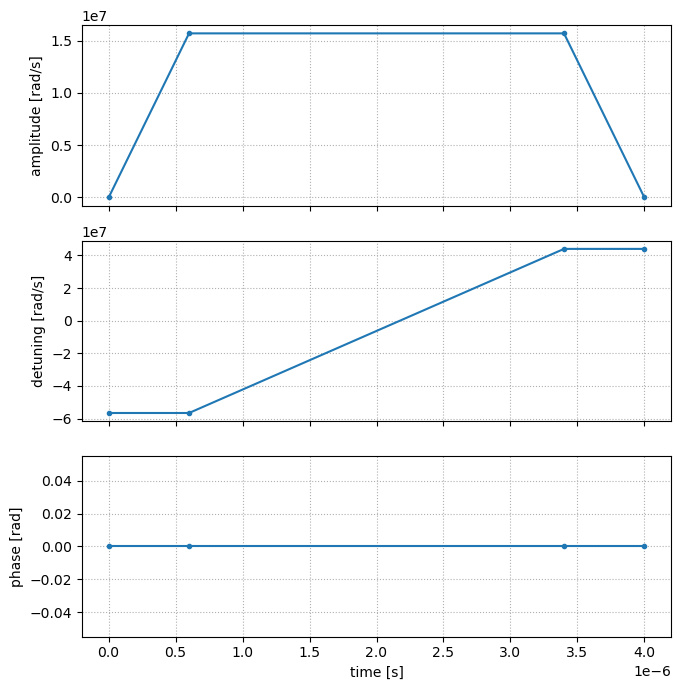

In [4]:
from utils import show_global_drive, get_drive

omega_min = 0       
omega_max = 2.5e6 * 2 * np.pi
detuning_min = -9e6 * 2 * np.pi
detuning_max = 7e6 * 2 * np.pi

time_max = 4e-6
time_ramp = 0.15*time_max

time_points = [0, time_ramp, time_max - time_ramp, time_max]
omega_values = [omega_min, omega_max, omega_max, omega_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, omega_values, detuning_values, phase_values)
H += drive

show_global_drive(drive)

However, that's not the full story. These drive terms alone don't tell us how the atoms interact. But interactions are at the core of many-body quantum physics! That's where the Rydberg blockade comes in. Mathematically, it is described by the term

\begin{align*}
H_{interaction} = \sum_{j<k} V_{jk}\hat{n}_j\hat{n}_k
\end{align*}

in the Rydberg Hamiltonian. The key idea is that within a certain distance - the so-called blockade radius - only one atom will be excited into an $\ket{r}$ state. Having more excitations will cost too much energy. This means that the states of two neighboring atoms will depend on each other and exhibit specific patterns which we will plot below. Creating these ordered states is non-trivial. Following the [adiabatic protocol](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/2.adiabatic/main/) mentioned previously is crucial since it allows us to slowly introduce these complex interactions into the system. 

<div class="alert alert-block alert-info">
    <b>Note: </b> In the current version of the AHS module in Braket, this Rydberg interaction term is automatically calculated from the atom positions. Hence, we don't need to worry about specifying it explicitly. Our Hamiltonian is all set!
</div>

### Defining the program (1D case)

Now, we can combine the register and Hamiltonian into a program. In particular, this program falls within the class of Analog Hamiltonian Simulation (AHS). If you're curious about other types of quantum computing, take a look at [gate-based circuits](https://github.com/aws/amazon-braket-examples/blob/main/examples/getting_started/1_Running_quantum_circuits_on_simulators/1_Running_quantum_circuits_on_simulators.ipynb) or tutorials on [quantum annealing](https://github.com/aws/amazon-braket-examples/blob/main/examples/quantum_annealing/Dwave_TravelingSalesmanProblem/Dwave_TravelingSalesmanProblem.ipynb).

In [6]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=H
)

### Simulation on classical hardware

Before submitting the task to run on actual quantum hardware, let's first check our program by running a local simulation on one of AWS's classical servers.

In [7]:
from braket.devices import LocalSimulator

classical_device = LocalSimulator("braket_ahs")

nshots = 1000
task = classical_device.run(ahs_program, shots=nshots)

# The result can be downloaded directly into an object in the python session:
result = task.result()

What phase of matter did we create? Let's have a look at the average density of atoms on each site:

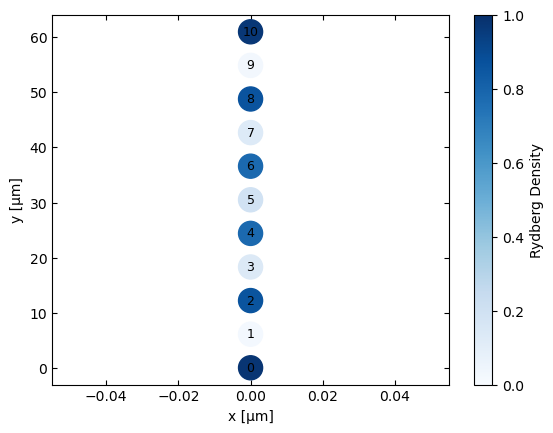

In [8]:
from utils import get_avg_density, plot_avg_density_2D

n_rydberg = get_avg_density(result)
plot_avg_density_2D(n_rydberg, register)

Indeed, we already see from this classical simulation that a pattern emerges: The alternating occupation density in the chain of atoms indicates a so-called $\mathbb{Z_2}$ phase. 

### Simulation on Aquila
And now for the truly exciting part! Let's bring Aquila into the game.
<div class="alert alert-block alert-info">
    <b>Note: </b> Running this program on the Aquila processor will incur a cost of 0.30 USD for submitting the program and 0.01 USD per shot. For scientific purposes, one would run this notebook with 1000 shots per task. To simply get a feel for the workflow of using Braket, however, we recommend reducing the number of shots. 
    Furthermore, AWS offers <a href="https://aws.amazon.com/braket/pricing/?loc=ft#AWS_Free_Tier">1 hour of free simulation time</a> per month. Running this notebook with 1000 shots would use xxx of your free computing time.
</div>

In [ ]:
from braket.aws import AwsDevice 

aquila = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# To make the program compatible with the quantum hardware, we still need to slice it into discrete time steps:
discretized_ahs_program = ahs_program.discretize(aquila)

task = aquila.run(discretized_ahs_program, shots=n_shots)
result = task.result()
show_final_avg_density(result)

<img src="1D_Aquila.svg" alt="1D_Aquila_Result" />

Success! We can clearly observe an alternating occupation density, i.e. the $\mathbb{Z}_2$ phase, just as in the previous classical simulation.

### 2D case

Now that we are familiar with the basic workflow, we can follow the same steps to extend our investigation to the 2D case. 

Let's start off with a simple square lattice with 3x3 atoms. Why? This system is again small enough to first simulate it on classical hardware and thus benchmark the quantum device. 

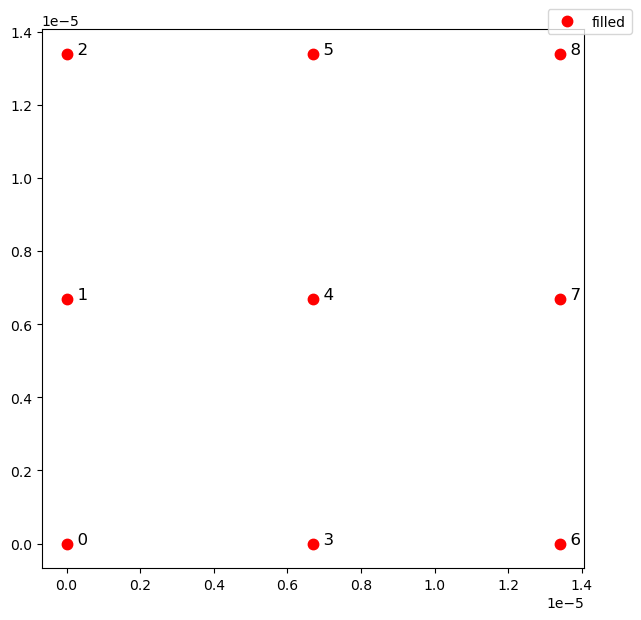

In [11]:
b = 6.7e-6  # meters
N_x = N_y = 3

register_2D = AtomArrangement()
for i in range(N_x):
    for j in range(N_y):
        register_2D.add([i*b, j * b])

show_register(register_2D)

In [14]:
H_2D = Hamiltonian()

omega_min = 0       
omega_max = 2.5e6 * 2 * np.pi
detuning_min = -8.75e6 * 2 * np.pi
detuning_max = 8.75e6 * 2 * np.pi

time_max = 3e-6
time_ramp = 0.25e-6

time_points = [0, time_ramp, time_max - time_ramp, time_max]
omega_values = [omega_min, omega_max, omega_max, omega_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive_2D = get_drive(time_points, omega_values, detuning_values, phase_values)
H_2D += drive_2D

Now, we run the simulation on classical hardware: 

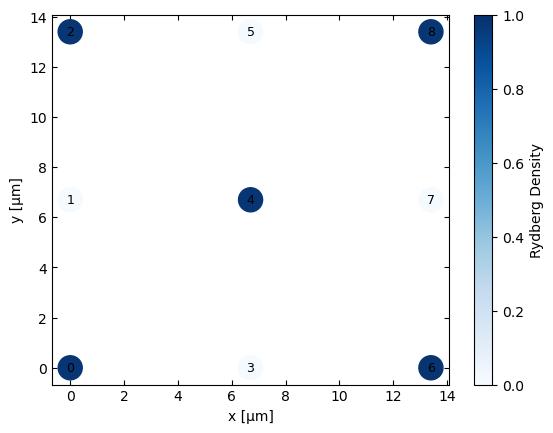

In [15]:
ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=H_2D
)

result_2D = classical_device.run(ahs_program_2D, shots=nshots).result()

plot_avg_density_2D(get_avg_density(result_2D), register_2D)

Great! We see a pattern emerging, similar to the $\mathbb{Z}_2$ phase in the 1D case. In 2D, this pattern is typically referred to as the checkerboard phase.

But will we observe the same behavior on Aquila?

In [ ]:
discretized_ahs_program_2D = ahs_program_2D.discretize(aquila)

result_2D = aquila.run(discretized_ahs_program_2D, shots=nshots).result()
plot_avg_density_2D(get_avg_density(result_2D), register_2D);

<img src="2D_Aquila.svg" alt="2D_Aquila_result"/>

### Finale: Moving beyond classical limits

So what's the big picture? We've walked through two best practice examples of simulating the order in a quantum many-body system, first on classical hardware and then on an actual quantum device, namely Aquila. 

But what's the advantage in using Aquila? Well, having gained confidence in Aquila, we can use this quantum device to move into a regime that is not so easy to simulate classically. To give you an impression, let's make one final plot showing the order of an 11x11 square lattice of neutral atoms.

In [27]:
b = 6.7e-6  # meters
N_x = N_y = 11

register_finale = AtomArrangement()
for i in range(N_x):
    for j in range(N_y):
        register_finale.add([j*b, i * b])

In [ ]:
ahs_program_finale = AnalogHamiltonianSimulation(
    register=register_finale, 
    hamiltonian=H_2D
)

result_2D = aquila.run(ahs_program_2D, shots=nshots).result()

plot_avg_density_2D(get_avg_density(result_2D), register_2D);

<img src="2D_11x11_Aquila.svg" alt="2D_11x11_Aquila_Result"/>

Indeed, the checkerboard phase clearly emerges. We have successfully created a complex many-body quantum state in which 121 atoms interact in Aquila to create an ordered phase of matter! 

### Connecting to Braket

Now that you've understood the basic workflow of using the Braket SDK you are ready to start submitting your own tasks to Aquila for real. Before heading over to the [full Braket documentation page](https://docs.aws.amazon.com/braket/latest/developerguide/what-is-braket.html), here's an outline of the five most important steps you will be taken through there:

1. [Create an AWS account](https://aws.amazon.com/free/?all-free-tier.sort-by=item.additionalFields.SortRank&all-free-tier.sort-order=asc&awsf.Free%20Tier%20Types=*all&awsf.Free%20Tier%20Categories=*all) for free.
2. [Open the Braket console](https://signin.aws.amazon.com/signin?redirect_uri=https%3A%2F%2Fus-east-1.console.aws.amazon.com%2Fbraket%3FhashArgs%3D%2523%26isauthcode%3Dtrue%26region%3Dus-east-1%26state%3DhashArgsFromTB_us-east-1_20274c425666f960&client_id=arn%3Aaws%3Asignin%3A%3A%3Aconsole%2Faqx&forceMobileApp=0&code_challenge=9RCx9puSjDUb1ybh7QD_6ISdRhdFrgRQzISNvKb5oDA&code_challenge_method=SHA-256).
3. Head to the Permissions & Settings subpage to [enable Braket](https://docs.aws.amazon.com/braket/latest/developerguide/braket-enable-overview.html). 
4. Stay on the Permissions & Settings subpage to [enable third-party devices](https://docs.aws.amazon.com/braket/latest/developerguide/braket-enable-third-party.html) (such as QuEra's Aquila).
5. Get started on [your first notebook](https://docs.aws.amazon.com/braket/latest/developerguide/braket-get-started-create-notebook.html!)! (All the code above is also available as one complete notebook in QuEra's public GitHub repository [here](https://github.com/QuEraComputing/braket-end-to-end-examples/blob/main/prototyping/HelloBraket_OrderedPhases.ipynb). You can copy-paste the url into an AWS notebook instance if you want to try the code out for real!)

Aquila is at your fingertips!